## CS203 Lab 1

### Team Number: 18
* Name: Paras Prashant Shirvale
* Roll No: 23110232 
---
* Name: Akshat Shah
* Roll No: 23110293
---

### Task 1: Setup the Dataset

Load the MNIST dataset using the Hugging Face datasets library.

In [66]:
import numpy as np
from datasets import load_dataset

In [67]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Check the structure of the dataset
print(mnist)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


Split the dataset into training and testing sets. And then convert the image data into Numpy arrays and normalize pixel values to the range [0,1].

In [68]:
# Get the train and test datasets
train_data = mnist['train']
test_data = mnist['test']

In [69]:
# Convert the images to numpy arrays and normalize them
train_images = np.array(train_data['image'])
test_images = np.array(test_data['image'])

In [70]:

# Normalize the pixel values to the range [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

In [71]:
# Check the shape and max, min value of the data to verify
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)


Flatten each image into a vector of 784 features.

In [72]:
# Flatten each image into a vector of 784 features (28x28 = 784)
train_images_flattened = train_images.reshape(train_images.shape[0], -1)  # shape: (num_samples, 784)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)  # shape: (num_samples, 784)

In [73]:
# Check the shape of the flattened data
print(f"Train images shape after flattening: {train_images_flattened.shape}")
print(f"Test images shape after flattening: {test_images_flattened.shape}")

Train images shape after flattening: (60000, 784)
Test images shape after flattening: (10000, 784)


In [74]:
# Get the labels (digits)
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])

Randomly select an initially labeled dataset of 200 samples from training samples.

In [75]:
# Randomly select 200 samples from the training set
num_samples = 200
random_indices = np.random.choice(train_images_flattened.shape[0], num_samples, replace=False)

In [76]:
# Create the initially labeled dataset
initial_images = train_images_flattened[random_indices]
initial_labels = train_labels[random_indices]


In [77]:
# Check the shape of the selected dataset
print(f"Initial labeled dataset shape (images): {initial_images.shape}")
print(f"Initial labeled dataset shape (labels): {initial_labels.shape}")

Initial labeled dataset shape (images): (200, 784)
Initial labeled dataset shape (labels): (200,)


Generate an "Unlabeled Pool," the Initial Dataset excluding 200 samples.

In [78]:
# Create the Unlabeled Pool by excluding the 200 selected samples
unlabeled_images = np.delete(train_images_flattened, random_indices, axis=0)
unlabeled_labels = np.delete(train_labels, random_indices, axis=0)

In [79]:
# Check the shape of the Unlabeled Pool
print(f"Unlabeled Pool shape (images): {unlabeled_images.shape}")
print(f"Unlabeled Pool shape (labels): {unlabeled_labels.shape}")

Unlabeled Pool shape (images): (59800, 784)
Unlabeled Pool shape (labels): (59800,)


### Task 2: Implement Random Sampling for Active Learning

1. Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [81]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [82]:
# Train the model on the initial labeled dataset (200 samples)
rf_classifier.fit(initial_images, initial_labels)

RandomForestClassifier(random_state=42)

In [83]:
# Evaluate the model on the Test Pool (10,000 samples)
# We will use the accuracy score to see how well the model performs
predicted_labels = rf_classifier.predict(test_images_flattened)

# Optionally, calculate accuracy (here we're using the true labels to compute accuracy)
accuracy = accuracy_score(test_labels, predicted_labels)

print(f"Accuracy on Test Pool: {accuracy * 100:.2f}%")

Accuracy on Test Pool: 77.29%


In [84]:
# Evaluate the model on the Unlabeled Pool (remaining 58,800 samples)
# We will use the accuracy score to see how well the model performs
predicted_labels = rf_classifier.predict(unlabeled_images)

# Optionally, calculate accuracy (here we're using the true labels to compute accuracy)
accuracy = accuracy_score(unlabeled_labels, predicted_labels)

print(f"Accuracy on Unlabeled Pool: {accuracy * 100:.2f}%")

Accuracy on Unlabeled Pool: 76.22%


2. Implement an active learning loop for 20 iterations:
* Randomly select a sample from the unlabeled pool.
* Get the selected sample and its true label.
* Add the sample and label to the labeled dataset.
* Remove the selected sample and label from the pool.
* Retrain the model on the updated dataset.
* Check the model's accuracy on the test set.
* Print accuracy after every iteration.


In [85]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_sampling_accuracies = []

# Active learning loop for 20 iterations
num_iterations = 20
for iteration in range(num_iterations):
    # Step 1: Randomly select a sample from the unlabeled pool
    random_index = np.random.choice(unlabeled_images.shape[0], 1, replace=False)
    selected_image = unlabeled_images[random_index]
    selected_label = unlabeled_labels[random_index]

    # Step 2: Add the selected sample and its label to the labeled dataset
    initial_images = np.vstack([initial_images, selected_image])
    initial_labels = np.append(initial_labels, selected_label)

    # Step 3: Remove the selected sample and label from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, random_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, random_index, axis=0)

    # Step 4: Retrain the model on the updated dataset
    rf_classifier.fit(initial_images, initial_labels)

    # Step 5: Evaluate the model on the test set
    predicted_labels_test = rf_classifier.predict(test_images_flattened)
    accuracy_test = accuracy_score(test_labels, predicted_labels_test)
    random_sampling_accuracies.append(accuracy_test)

    # Step 6: Print accuracy after every iteration
    print(f"Iteration {iteration+1}/{num_iterations} - Test Accuracy: {accuracy_test * 100:.2f}%")


Iteration 1/20 - Test Accuracy: 77.55%
Iteration 2/20 - Test Accuracy: 78.82%
Iteration 3/20 - Test Accuracy: 79.29%
Iteration 4/20 - Test Accuracy: 79.04%
Iteration 5/20 - Test Accuracy: 79.05%
Iteration 6/20 - Test Accuracy: 78.35%
Iteration 7/20 - Test Accuracy: 78.46%
Iteration 8/20 - Test Accuracy: 78.50%
Iteration 9/20 - Test Accuracy: 78.97%
Iteration 10/20 - Test Accuracy: 79.75%
Iteration 11/20 - Test Accuracy: 78.88%
Iteration 12/20 - Test Accuracy: 79.40%
Iteration 13/20 - Test Accuracy: 79.08%
Iteration 14/20 - Test Accuracy: 78.49%
Iteration 15/20 - Test Accuracy: 80.14%
Iteration 16/20 - Test Accuracy: 80.53%
Iteration 17/20 - Test Accuracy: 80.26%
Iteration 18/20 - Test Accuracy: 80.13%
Iteration 19/20 - Test Accuracy: 80.92%
Iteration 20/20 - Test Accuracy: 80.69%


### Task 3: Implement Uncertainty Sampling for Active Learning.

1. Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.

In [86]:
# # Randomly select 200 samples from the training set
# num_samples = 200
# random_indices = np.random.choice(train_images_flattened.shape[0], num_samples, replace=False)

# # Create the initially labeled dataset
# initial_images = train_images_flattened[random_indices]
# initial_labels = train_labels[random_indices]

In [87]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the initial labeled dataset (200 samples)
rf_classifier.fit(initial_images, initial_labels)

# Predict the labels on the test dataset
predicted_labels_test = rf_classifier.predict(test_images_flattened)

# Calculate the accuracy on the test dataset
accuracy_test = accuracy_score(test_labels, predicted_labels_test)

# Print the accuracy
print(f"Accuracy on Test Set after training on 200 samples: {accuracy_test * 100:.2f}%")

Accuracy on Test Set after training on 200 samples: 80.69%


2. Implement an active learning loop for 20 iterations:
* Compute uncertainty (Label Entropy) for each sample in the unlabeled pool using entropy.
* Select the sample with the highest uncertainty and query its true label.
* Add the queried sample to the labelled dataset and remove it from the unlabelled pool.
* Retrain the model and check the model's accuracy on the test set.
* Print accuracy after every iteration.


In [88]:
# Function to compute the entropy for each sample
def compute_label_entropy(model, unlabeled_images):
    # Get the predicted probabilities for each class (model.predict_proba returns a probability distribution for each class)
    probas = model.predict_proba(unlabeled_images)
    
    # For each sample, calculate entropy
    entropies = []
    for prob in probas:
        entropy = -np.sum(prob * np.log2(prob + 1e-10))  # Adding a small value to avoid log(0)
        entropies.append(entropy)
    
    return np.array(entropies)

In [89]:
uncertainty_sampling_accuracies = []

# Active learning loop for 20 iterations
num_iterations = 20
for iteration in range(num_iterations):
    
    # Step 1: Compute Label Entropy for each sample in the unlabeled pool
    entropies = compute_label_entropy(rf_classifier, unlabeled_images)
    
    # Step 2: Select the sample with the highest entropy (highest uncertainty)
    uncertain_sample_index = np.argmax(entropies)
    selected_image = unlabeled_images[uncertain_sample_index]
    selected_label = unlabeled_labels[uncertain_sample_index]
    
    # Step 3: Add the selected sample and label to the labeled dataset
    initial_images = np.vstack([initial_images, selected_image])
    initial_labels = np.append(initial_labels, selected_label)
    
    # Step 4: Remove the selected sample and label from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_sample_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_sample_index, axis=0)
    
    # Step 5: Retrain the model on the updated labeled dataset
    rf_classifier.fit(initial_images, initial_labels)
    
    # Step 6: Evaluate the model on the test set
    predicted_labels_test = rf_classifier.predict(test_images_flattened)
    accuracy_test = accuracy_score(test_labels, predicted_labels_test)
    uncertainty_sampling_accuracies.append(accuracy_test)
    
    # Step 7: Print the accuracy after every iteration
    print(f"Test Accuracy after iteration {iteration + 1}: {accuracy_test * 100:.2f}%")


Test Accuracy after iteration 1: 80.56%
Test Accuracy after iteration 2: 80.67%
Test Accuracy after iteration 3: 80.10%
Test Accuracy after iteration 4: 81.44%
Test Accuracy after iteration 5: 81.29%
Test Accuracy after iteration 6: 81.67%
Test Accuracy after iteration 7: 81.63%
Test Accuracy after iteration 8: 81.84%
Test Accuracy after iteration 9: 81.38%
Test Accuracy after iteration 10: 81.42%
Test Accuracy after iteration 11: 80.91%
Test Accuracy after iteration 12: 82.05%
Test Accuracy after iteration 13: 82.36%
Test Accuracy after iteration 14: 82.51%
Test Accuracy after iteration 15: 82.46%
Test Accuracy after iteration 16: 82.59%
Test Accuracy after iteration 17: 82.98%
Test Accuracy after iteration 18: 81.78%
Test Accuracy after iteration 19: 82.02%
Test Accuracy after iteration 20: 81.97%


### Task 4: Implement Query-by-Committee for Active Learning

1. Initialize a committee of 5 Random Forest models, each trained on the initial dataset.


In [98]:
# Number of models in the committee
num_models = 5

# Initialize an empty dictionary to hold the models (the committee)
committee = {}

# Initialize and train 5 Random Forest models on the initial dataset
for i in range(1, num_models + 1):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(initial_images, initial_labels)
    model_name = f"rf_classifier_{i}"  # Generate a unique name for each classifier
    committee[model_name] = rf_classifier  # Add the trained model to the committee with the unique name

# Print out the number of models in the committee and their names
print(f"Committee of {len(committee)} Random Forest models initialized and trained:")
for model_name in committee:
    print(f"- {model_name}")


Committee of 5 Random Forest models initialized and trained:
- rf_classifier_1
- rf_classifier_2
- rf_classifier_3
- rf_classifier_4
- rf_classifier_5


2. In the active learning loop for 20 iterations:
* For each unlabeled sample, compute predictions from all committee members.
* Measure disagreement by calculating Vote Entropy.
* Select the sample with the highest disagreement and query its true label.
* Update the labelled dataset and retrain all models.
* Check the model's accuracy on the test set.
* Print accuracy after every iteration


In [ ]:
def vote_entro(data, committee):
    predictions = []
    for model_name in committee:
        model = committee[model_name]
        predicted_labels = model.predict(data)
        predictions.append(predicted_labels)
    predictions = np.array(predictions)
    print(predictions.shape)
    return predictions

In [91]:
# Function to compute Vote Entropy for a given set of predictions
def vote_entropy(predictions):
    total_entropy = 0
    for sample_predictions in predictions:
        unique_votes, counts = np.unique(sample_predictions, return_counts=True)
        probabilities = counts / len(sample_predictions)
        sample_entropy = -np.sum(probabilities * np.log10(probabilities))
        total_entropy += sample_entropy
    return total_entropy / len(predictions)

In [92]:
# Active learning loop for 20 iterations
num_iterations = 20
committee_sampling_accuracies = []

for iteration in range(num_iterations):
    
    # Step 1: Compute predictions from all committee members for each sample in the unlabeled pool
    committee_predictions = np.array([model.predict(unlabeled_images) for model in committee]).T  # Shape: (num_samples, num_models)
    
    # Step 2: Calculate Vote Entropy for each sample in the unlabeled pool
    vote_entropies = np.array([vote_entropy(committee_predictions[i:i+1]) for i in range(committee_predictions.shape[0])])
    
    # Step 3: Select the sample with the highest Vote Entropy (highest disagreement)
    uncertain_sample_index = np.argmax(vote_entropies)
    selected_image = unlabeled_images[uncertain_sample_index]
    selected_label = unlabeled_labels[uncertain_sample_index]
    
    # Step 4: Add the selected sample and its true label to the labeled dataset
    initial_images = np.vstack([initial_images, selected_image])
    initial_labels = np.append(initial_labels, selected_label)
    
    # Step 5: Remove the selected sample and label from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_sample_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_sample_index, axis=0)
    
    # Step 6: Retrain all models in the committee on the updated labeled dataset
    for model in committee:
        model.fit(initial_images, initial_labels)
    
    # Step 7: Evaluate the model on the test set
    test_predictions = np.array([model.predict(test_images_flattened) for model in committee]).T
    test_accuracy = accuracy_score(test_labels, test_predictions.mean(axis=1).round())  # Majority vote from the committee
    committee_sampling_accuracies.append(test_accuracy)
    
    # Step 8: Print accuracy after every iteration
    print(f"Test Accuracy after iteration {iteration + 1}: {test_accuracy * 100:.2f}%")

Test Accuracy after iteration 1: 82.77%
Test Accuracy after iteration 2: 82.39%
Test Accuracy after iteration 3: 83.18%
Test Accuracy after iteration 4: 82.84%
Test Accuracy after iteration 5: 83.20%
Test Accuracy after iteration 6: 82.27%
Test Accuracy after iteration 7: 83.05%
Test Accuracy after iteration 8: 82.82%
Test Accuracy after iteration 9: 82.70%
Test Accuracy after iteration 10: 82.27%
Test Accuracy after iteration 11: 82.77%
Test Accuracy after iteration 12: 82.81%
Test Accuracy after iteration 13: 83.37%
Test Accuracy after iteration 14: 83.05%
Test Accuracy after iteration 15: 83.08%
Test Accuracy after iteration 16: 82.86%
Test Accuracy after iteration 17: 82.91%
Test Accuracy after iteration 18: 83.23%
Test Accuracy after iteration 19: 82.71%
Test Accuracy after iteration 20: 82.78%


### Task 5 : Evaluation & Report

1) Compare the final model accuracy across all three strategies.



* Random Sampling → Final Accuracy = 80.69%
* Uncertainty Sampling → Final Accuracy = 81.97%
* Query-by-Committee → Final Accuracy = 82.78%
Highest Accuracy was given by the Query-by-Committee approach

2) Plots the graph of accuracies for all three methods for 20 iterations.

In [2]:
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

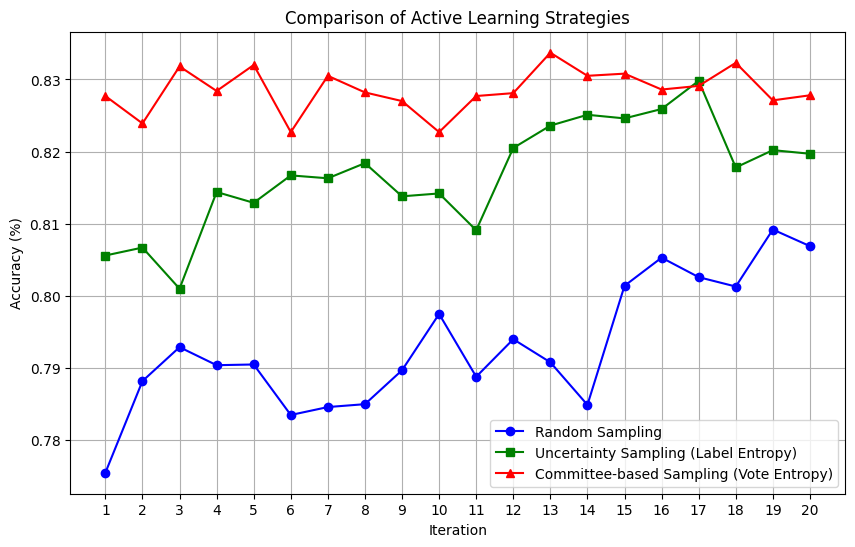

In [94]:
# Plotting the results
iterations = np.arange(1, 21)

plt.figure(figsize=(10, 6))
plt.plot(iterations, random_sampling_accuracies, label="Random Sampling", marker='o', linestyle='-', color='blue')
plt.plot(iterations, uncertainty_sampling_accuracies, label="Uncertainty Sampling (Label Entropy)", marker='s', linestyle='-', color='green')
plt.plot(iterations, committee_sampling_accuracies, label="Committee-based Sampling (Vote Entropy)", marker='^', linestyle='-', color='red')

plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Active Learning Strategies')
plt.legend(loc="lower right")
plt.grid(True)
plt.xticks(iterations)
plt.show()

3) Analyze which method leads to the most cost-effective improvement in accuracy.

- **Random Sampling:** Simple to implement but inefficient; may not significantly enhance accuracy.  
- **Uncertainty Sampling:** More efficient as it prioritizes challenging samples, accelerating learning.  
- **Query-by-Committee:** Computationally demanding but can improve generalization if model disagreements are meaningful.

4) Discuss findings and limitations in a brief report.

 **Findings:**  
- **Query-by-Committee** achieved the highest final accuracy but required significant computational resources.  
- **Uncertainty Sampling** improved accuracy more quickly than **Random Sampling** but was prone to noise sensitivity.  
- **Random Sampling** showed the slowest improvement and was the least efficient.  

 **Limitations:**  
- Accuracy fluctuations due to the small initial training set.  
- **Uncertainty Sampling** was vulnerable to mislabeled samples, affecting performance.  
- **Query-by-Committee** incurred high computational costs due to training multiple models.

**Conclusion**  
For a balance of efficiency and accuracy in cost-effective active learning, *Uncertainty Sampling* is the best choice. However, if computational cost isn't a limiting factor, *Query-by-Committee* delivers the highest final accuracy. 